In [638]:
## Goal : recreate the image 
## data creation =>>> CIFAR10 image data, create a binary mask and make masked image data from this.
## inputs =>>>  masked_image and mask
## outputs =>>>  image
## network  =>>>  CNN
## loss function =>>> Least squares

In [639]:
import torch
from torchvision.datasets import CIFAR10
from torch.nn import Module, MSELoss, Sequential
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

## Step1_Data Preparation using CIFAR10 dataset

In [640]:
n_samples = 1000
Train_dataset = CIFAR10(root = './data', train = True, download = True).data[0:n_samples]

Files already downloaded and verified


## Image masking with openCV

In [641]:
# reality deterioration in images is not just a square bob. So, I chose to use irregular holes.
# simply drew lines of random length and thickness using OpenCV

(32, 32, 1)


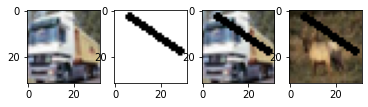

masked_image_data.shape:  (1000, 32, 32, 3) , Train_dataset.shape (1000, 32, 32, 3)


In [642]:
mask = np.full((32,32,3), 255, np.uint8)          # White background

# random x locations to start line
x1, x2 = np.random.randint(1,33), np.random.randint(1,33)

# random y locations to start line
y1, y2 = np.random.randint(1,33),np.random.randint(1,33)

# random thickness
thickness = np.random.randint(2, 4)

# Draw black line on the white mask
cv2.line(mask, (x1,y1), (x2,y2), (0,0,0), thickness)

# convert mask to gray scale as there are only two colors - black and white - 0 and 1 
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) / 255
mask = np.expand_dims(mask, axis=2)

print(mask.shape)
 
masked_image_data = Train_dataset * mask / 255

# testing on how data looks

f, axis = plt.subplots(1, 4)
f.set_figheight(6)
f.set_figwidth(6)    

axis[0].imshow(Train_dataset[1]) 
axis[1].imshow(mask, cmap = 'gray')
axis[2].imshow(masked_image_data[1])
axis[3].imshow(masked_image_data[3])

plt.show()

print('masked_image_data.shape: ', masked_image_data.shape, ', Train_dataset.shape', Train_dataset.shape)


In [643]:
## convert to Tensors
Train_dataset = torch.reshape(torch.as_tensor(np.array(Train_dataset)), (n_samples, 3, 32, 32)).double()
mask = torch.reshape(torch.as_tensor(np.array(mask)), (1, 32, 32)).double()
masked_image_data = torch.reshape(torch.as_tensor(np.array(masked_image_data)), (n_samples, 3, 32, 32))
masked_image_data = masked_image_data.double()
print('masked_image_data.shape: ', masked_image_data.shape, 'Train_dataset.shape : ',Train_dataset.shape, 'mask.shape: ', mask.shape)

masked_image_data.shape:  torch.Size([1000, 3, 32, 32]) Train_dataset.shape :  torch.Size([1000, 3, 32, 32]) mask.shape:  torch.Size([1, 32, 32])


## Step2_ Defining the model input and output

In [644]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size = 1),
        nn.ReLU(),
        nn.Conv2d(out_c, out_c, kernel_size = 1),
        nn.ReLU()
    )
    return conv

# def crop_image(tensor, target_tensor):
#     target_size = target_tensor.size()[2]
#     tensor_size = tensor.size()[2]
#     delta = tensor_size - target_size
#     delta = delta // 2
#     return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]
    

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__() 

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.down_conv_1 = double_conv(3, 16) 
        self.down_conv_2 = double_conv(16, 32) 
        self.down_conv_3 = double_conv(32, 64) 

        
        self.up_transconv_1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2)
        self.up_conv_1 = double_conv(64, 32)
        self.up_transconv_2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 2, stride = 2)
        self.up_conv_2 = double_conv(32, 3)        
        
    def forward(self, image):
        # encoder
        x1 = self.down_conv_1(image) # N, 3, 32, 32 - >> N, 16, 32, 32
        x2 = self.max_pool_2x2(x1) # N, 16, 32, 32 - >> N , 16, 16, 16 
        x3 = self.down_conv_2(x2) # N , 16, 16, 16  ->> N , 32, 16, 16 
        x4 = self.max_pool_2x2(x3) # N , 32, 16, 16 - >> N , 32, 8, 8
        x5 = self.down_conv_3(x4) # N , 32, 8, 8   ->> N, 64, 8, 8 
        
        # decoder
        x = self.up_transconv_1(x5)  # N , 64, 8, 8  ->>  N , 32, 16, 16
        x = self.up_conv_1(torch.cat([x, x3])) # N , 64, 16, 16 ->> N, 32, 16, 16 
        x = self.up_transconv_2(x)  # N , 32, 16, 16  ->>  N , 16, 32, 32
        x = self.up_conv_2(torch.cat([x, x1])) # ->> N, 32, 32, 32 ->> N, 3, 32, 32       
        
 
        return x    

## CUDA - To run everything in GPU 

In [645]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
# print(device)

# Run the model in GPU
#model.to(device)

## Step3_Model ingredients

In [646]:
criterion = nn.MSELoss()       #Loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  #Optimizer

## Step4_Model Training - forward, backward, weight updates

In [647]:
n_epochs = 1000                    # number of iterations that has to be done
for epoch in range(1, n_epochs+1):
    
    #plt.imshow(mask, cmap = 'gray')
    
    model.double()
    
    # data to GPU

    # forward pass -> model predictions and Loss
    outputs = model(masked_image_data) 
    
    # Loss calculation
    loss = criterion(outputs * mask, masked_image_data)
    
    # backward pass -> calculate gradients 
    loss.backward()
    
    # weights update from the optimizer
    optimizer.step()
    
    # zeroing gradients before next iteration
    optimizer.zero_grad()
    
    # print the loss
    if epoch % 300 == 0:
        print(loss)

tensor(0.0477, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0462, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.0452, dtype=torch.float64, grad_fn=<MseLossBackward0>)


## Step5_Plotting results

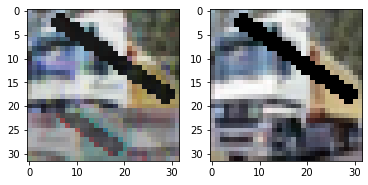

In [648]:
# reshaping before inputting to imshow()
outputs = torch.reshape(outputs, (n_samples, 32, 32, 3))
masked_image_data = torch.reshape(masked_image_data, (n_samples, 32, 32, 3)) 

# plottings using matplotlib.pyplot subplots
f, axis = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(6)      

# plt.imshow((out * 255).astype(np.uint8))
# print(outputs[1], masked_image_data[1])
# print(outputs[1].min())

axis[0].imshow(outputs[1].cpu().detach().numpy(), label = 'network_output_image')
axis[1].imshow(masked_image_data[1].cpu().detach().numpy(), label = 'target_image')

plt.savefig('avgpool_comparision.png', format = 'png')

## Conclusion 

In [347]:
## looks impressive with u-net architecture.